# Assignment - Principal Component Analysis


## Authors
V. Aquiviva and B.W. Holwerda

## Learning Goals
* Principal Component Analysis
* Decomposing spectra
* Judging the number of components to use in PCA
* Optimal number of components

## Keywords
python, syntax, jupyter notebook, PCA, Correlation, Optimization

## Companion Content


## Summary
Principal components are the eigenvectors of a data feature space. By determining these, one can reduce the dimensionality of the parameter space while keeping most if not all the information in the feature space. Here we will illustrate with spectra of stars.
<hr>

## Student Name and ID: YOUR NAME HERE (ID NUMBER)


## Date: 

<hr>

# Do a PCA decomposition of the Pickles Spectroscopic library

This can be done in a variety of ways - depending on what data we focus on.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import seaborn as sns
import scipy
from scipy.stats.mstats import pearsonr
from scipy.stats.mstats import spearmanr

%matplotlib inline

## Loading of the library of spectra

The spectra are stored in a FITS file in the Pickles subdirectory called `pickles-spectra.fits`. This contains the wavelength axis in the first HDU, the flux in the next and the flux uncertainty in the last. But we also need to get the overview table which has the classification of the spectra.

In [6]:
def load_pickles_library():
    hdul = fits.open('pickles-spectra.fits')
    wave = hdul[0].data
    flux = hdul[1].data
    dflux = hdul[2].data
    
    return wave, flux, dflux

def load_overview_table():
    return Table().read('overview-of-spectra.vot')

In [7]:
wave, flux, dflux = load_pickles_library()
t_overview = load_overview_table()
t_overview

SPType,Lumclass,Metal,numtype,metflag,numlclass,file
str1,str3,str3,float64,int64,int64,str12
a,i,uk,3.0,1,1,uka0i.dat
a,iii,uk,3.0,1,3,uka0iii.dat
a,iv,uk,3.0,1,4,uka0iv.dat
a,v,uk,3.0,1,5,uka0v.dat
a,i,uk,3.2,1,1,uka2i.dat
a,v,uk,3.2,1,5,uka2v.dat
a,iii,uk,3.3,1,3,uka3iii.dat
a,v,uk,3.3,1,5,uka3v.dat
a,iv,uk,3.55,1,4,uka47iv.dat


## Examining a few spectra

Let us here plot the first spectrum in each class.

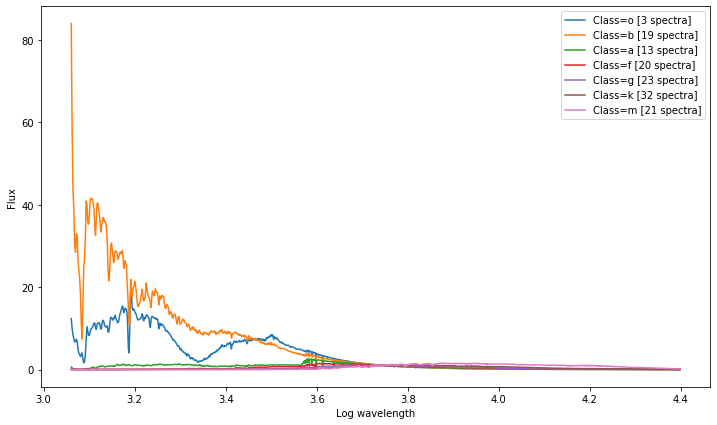

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,7))

MKclasses = ['o', 'b', 'a', 'f', 'g', 'k', 'm']
for MK in MKclasses:
    ii, = np.where(t_overview['SPType'] == MK)
    
    ax.plot(np.log10(wave), flux[:, ii[0]], label='Class={0} [{1} spectra]'.format(MK, len(ii)))
    
ax.set_xlabel('Log wavelength')
ax.set_ylabel('Flux')
ax.legend()

But of course that is not a very nice illustration. So let us focus on the optical region

In [9]:
i_optical, = np.where((wave > 3000) & (wave < 10000))
flux_opt = flux[i_optical, :]
dflux_opt = dflux[i_optical, :]
wave_opt = wave[i_optical]

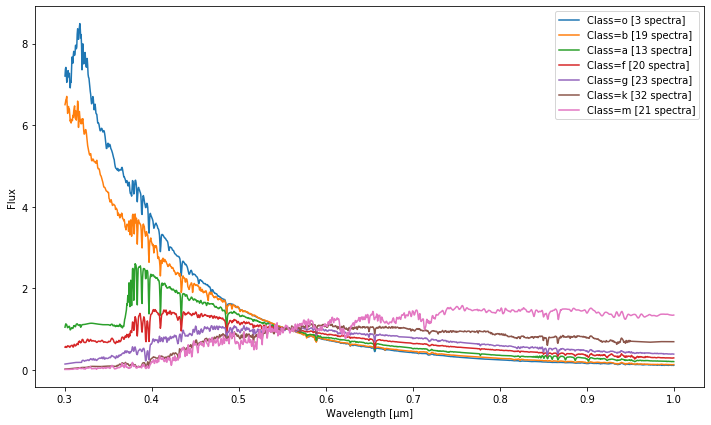

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,7))

MKclasses = ['o', 'b', 'a', 'f', 'g', 'k', 'm']
for MK in MKclasses:
    ii, = np.where(t_overview['SPType'] == MK)
    
    ax.plot(wave_opt/1e4, flux_opt[:, ii[0]], label='Class={0} [{1} spectra]'.format(MK, len(ii)))
    
ax.set_xlabel('Wavelength [µm]')
ax.set_ylabel('Flux')
ax.legend()

### Exercise 1

Are the spectra normalized somehow? How can you tell?

*student work here*

## Setting up for PCA

We now need to import the appropriate libraries for PCA.

In [11]:
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

In [12]:
# This does automatic whitening
pca = PCA(n_components=10, whiten=False)

In [13]:
# This is the design matrix (note the transpose to adhere to the sklearn convention)
X = flux_opt.T.copy()

# And we want to calculate a mean spectrum too.
mean_spectrum = np.sum(X, axis=0)/len(X[:,0])

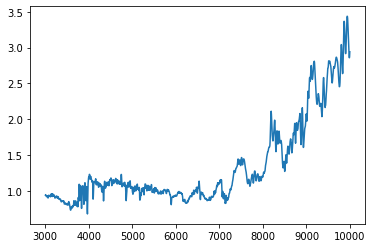

In [14]:
plt.plot(wave_opt, mean_spectrum)

In [15]:
X_zeromean = X.copy()
for i in range(131):
    X_zeromean[i, :] = X[i, :]-mean_spectrum

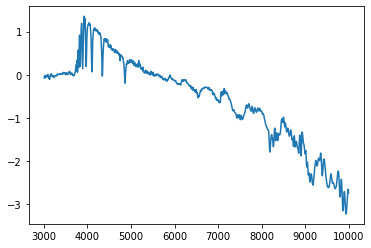

In [16]:
plt.plot(wave_opt, X_zeromean[5, :])

In [17]:
pca.fit(flux_opt.T)

PCA(n_components=10)

(0, 0.05)

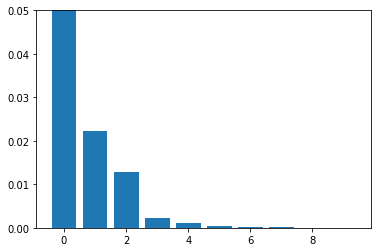

In [18]:
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.ylim(0, 0.05)

### Exercise 2

Does it look like we reallyneed all the principle components? 

*student answer here*

### Exercise 3

How many principal components do we need to concern ourselved with?

*student answer here*

## Looking at eigenspectra

Let us now see what the first few eigenspectra look like

In [19]:
pcs = pca.transform(X)

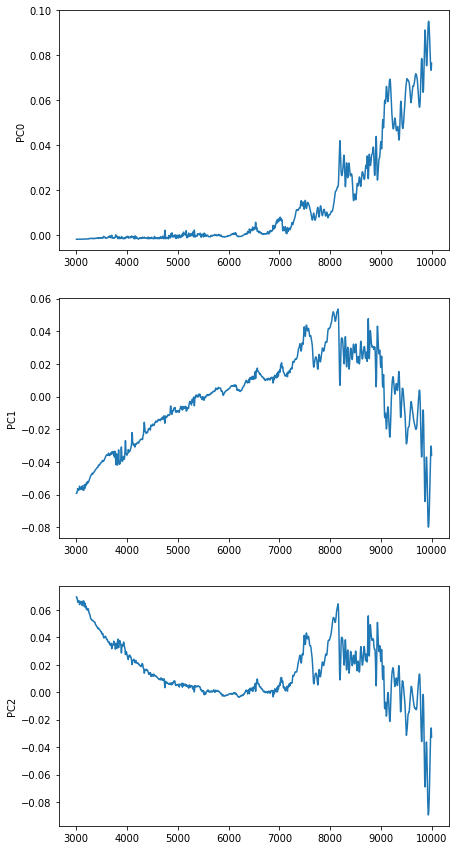

In [20]:
fig, ax = plt.subplots(nrows=3, figsize=(7, 15))
for i in range(3):
    ax[i].plot(wave_opt, pca.components_[i, :])
    ax[i].set_ylabel('PC{0}'.format(i))

## Visualise the principal components

For this we use the pcs that are calculated above. Here it is interesting to show this as a pair plot coloured by MKType and by luminosity class. 

In [21]:
dft = pd.DataFrame(pcs[:, 0:4], columns=('PC1', 'PC2', 'PC3', 'PC4'))

In [22]:
dft['type'] = t_overview['SPType']
dft['lumclass'] = t_overview['Lumclass']

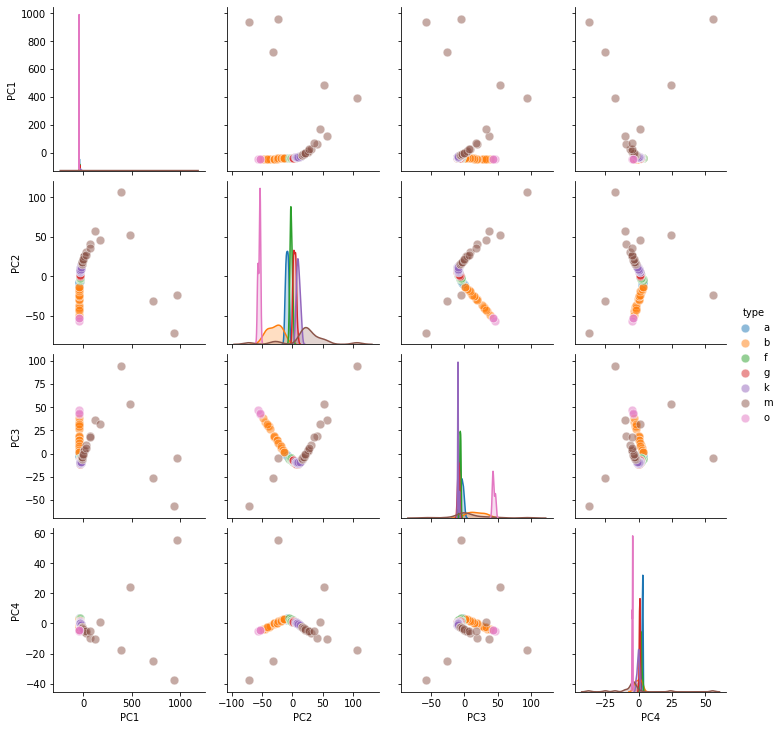

In [23]:
sns.pairplot(dft, hue='type', vars=('PC1', 'PC2', 'PC3', 'PC4'),
             plot_kws={'s': 75, 'alpha': 0.5})

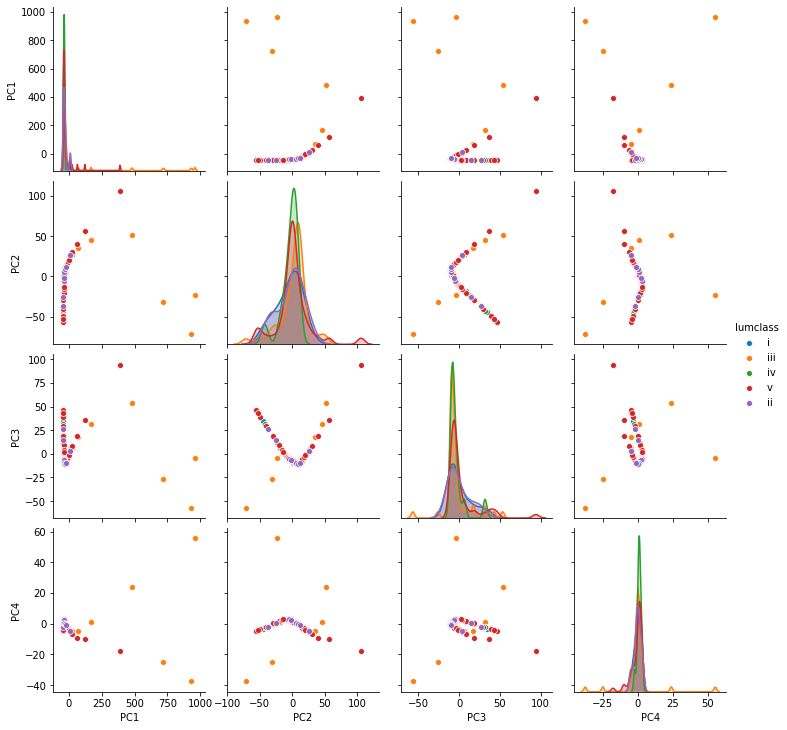

In [24]:
sns.pairplot(dft, hue='lumclass', vars=('PC1', 'PC2', 'PC3', 'PC4'))

### Exercise 4

Which two classifications seem to be correlated with the Principal Components? The Spectral type or the luminosity class? Motivate your anwer using the above two plots.


*student answer here*

### Exercise 5

So it seems as if there may be a correlation between MK spectral class and various PCs. 
We can explore this further by using a plot of PC against the numerical spectral class ('numtype') and the numerical luminosity class ('numlclass') in the t_overview table.

Plot the numerical spectra's type against the PC1, PC2 and PC3 in separate plots. 

In [25]:
# student work


### Exercise 6

So it looks like PCA reveals spectral type and seems unconcerned with luminosity type. 
We can check this intuition using correlation metrics. 

Which one should we use Spearman or Pearson?

*student answer here*

### Exercise 7

So it looks like PCA reveals spectral type and seems unconcerned with luminosity type. 
We can check this intuition using correlation metrics. If we check the Pearson or Spearman rankings 
between the numerical type or the luminosity type and the three principal components, which is
more closely related to the principal components, numerical type or luminosity type?


In [26]:
# Student work


# Reconstruction of spectra

We now want to reconstruct spectra and see how well that works.

In [27]:
sp_depr = pca.inverse_transform(pcs)

In [28]:
sp_depr.shape

(131, 1399)

Text(0, 0.5, 'Flux')

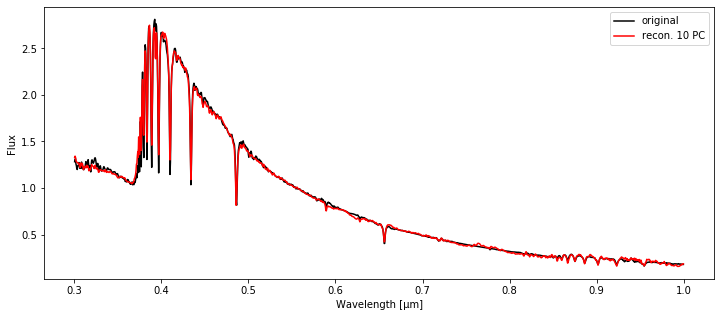

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(wave_opt/1e4, flux_opt[:, 30], color='black', label='original')
ax.plot(wave_opt/1e4, sp_depr[30, :], color='red', label='recon. 10 PC')
ax.legend()
ax.set_xlabel('Wavelength [µm]')
ax.set_ylabel('Flux')

### Exercise 8

is this a good description of the data? Would the addition of more principal components help?

*student answer here*

It is here probably more useful to explore the residual plot.

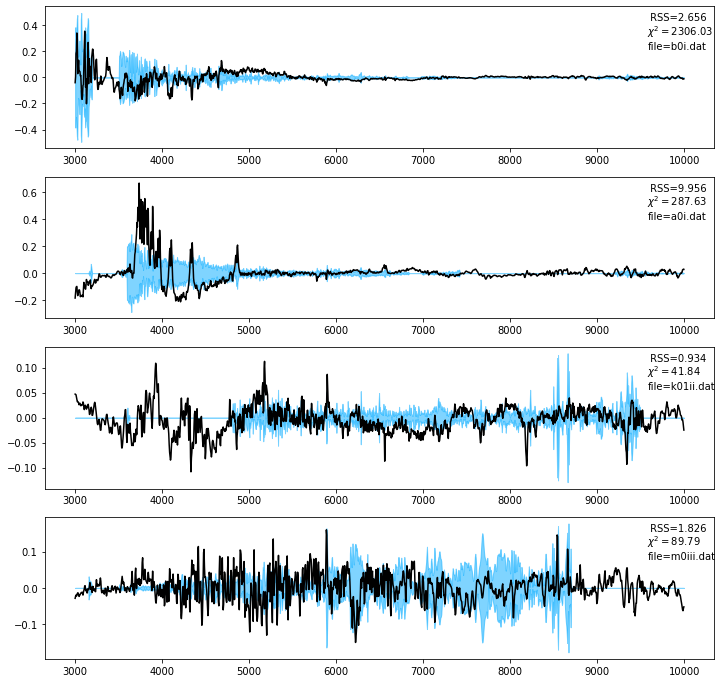

In [30]:
MKclasses = ['o', 'b', 'a', 'f', 'g', 'k', 'm']
MKclasses = ['b', 'a', 'k', 'm']
fig, ax = plt.subplots(figsize=(12, 12), nrows=len(MKclasses))
for i, MK in enumerate(MKclasses):
    ii, = np.where(t_overview['SPType'] == MK)
    ii = ii[0]
    diff = (flux_opt[:, ii]-sp_depr[ii, :])
    
    # Not every spectrum has an error estimate at all wavelengths.
    # To get a meaningful (ie. comparable) weighted RSS I want to normalise
    # by this.
    i_with_err, = np.where(dflux_opt[:, ii] > 0)
    n_with_err = len(i_with_err)
    rss = np.sum(diff**2)
    rss_w = np.nansum((diff[i_with_err]/dflux_opt[i_with_err, ii])**2)/n_with_err
    
    ax[i].plot(wave_opt, diff, color='black')
    ax[i].fill_between(wave_opt, dflux_opt[:, ii], -dflux_opt[:, ii],
                       color='#00aaff', alpha=0.5)
    ax[i].text(0.9, 0.9, ' RSS={0:.3f}'.format(rss), transform=ax[i].transAxes)
    ax[i].text(0.9, 0.8, r'$\chi^2={0:.2f}$'.format(rss_w), transform=ax[i].transAxes)
    ax[i].text(0.9, 0.7, 'file={0}'.format(t_overview['file'][ii][2:]), transform=ax[i].transAxes)

### Exercise 9

Now looking at the residual and the expected noise, are the spectra well described by the 10 PCA model? 

*student answer here*

# Determining the number of components needed

This requires some more calculation. Let us approach this from a cross-validation point of view. In that case we need to set up a cross-validation run, loop over this and run PCA with varying numbers of components and calculate the residual sum of squares (RSS) over the whole sample.

In [98]:
from sklearn.model_selection import KFold

X = flux.T
def do_one_cv_pca(X, n_components, n_splits=10):
    # Create folds for N data points in n_folds:
        
    kf = KFold(n_splits=n_splits)
    RSS = 0.0
    for train, test in kf.split(X):
        x_train = X[train, :]
        x_test = X[test, :]
    
        # Calculate PCA on the training sample.
        # This does automatic whitening
        pca = PCA(n_components=n_components, whiten=True)
        pca.fit(x_train)
    
        # Use this to reconstruct the test sample
        #pcs = pca.transform(x_test)
        #sp_depr = pca.inverse_transform(pcs)
    
        #RSS_this = np.sum((x_test-sp_depr)**2)
        RSS_this = pca.score(x_test)
        RSS += RSS_this
    
    return RSS


def do_multiple_n_comp(X):
    
    n_comps = np.arange(1, 50)
#    n_comps = np.arange(1, 120, 5)
    N = len(n_comps)
    RSS = np.zeros(N)
    for i, n_comp in enumerate(n_comps):
        print("Doing {0:2d}".format(i))
        RSS[i] = do_one_cv_pca(X, n_comp)
        
    return RSS, n_comps

### Run from 1 to 50 PCAs and compute the RSS

Here we run the PCA again and again using 1-50 components. This may take a while (like time to make a cup of tea) and then we plot the RSS against the number of components.

In [83]:
RSSes, n_comps = do_multiple_n_comp(X)

Doing  0
Doing  1
Doing  2
Doing  3
Doing  4
Doing  5
Doing  6
Doing  7
Doing  8
Doing  9
Doing 10
Doing 11
Doing 12
Doing 13
Doing 14
Doing 15
Doing 16
Doing 17
Doing 18
Doing 19
Doing 20
Doing 21
Doing 22
Doing 23
Doing 24
Doing 25
Doing 26
Doing 27
Doing 28
Doing 29
Doing 30
Doing 31
Doing 32
Doing 33
Doing 34
Doing 35
Doing 36
Doing 37
Doing 38
Doing 39
Doing 40
Doing 41
Doing 42
Doing 43
Doing 44
Doing 45
Doing 46
Doing 47
Doing 48


### Exercise 10

Plot the number of components against the RSS. The RSS has a wide range so you may have to use something to make the y-axis clear (normalize or use np.exp).

In [31]:
# #student work here


### Exercise 11

Would adding an 11th and 12th component improve the overall description? 

What does that tell us about the number of PC to use? 

*student answer here*